## Traditional methods of classification:
### Setup:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Function which acts as classification function:

In [2]:
def traditional_classifiers(X, y):
    y = pd.factorize(y)[0]  # This assigns unique integers to each species
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 1. Logistic Regression
    logistic_model = LogisticRegression(max_iter=50)
    logistic_model.fit(X_train_scaled, y_train)
    y_pred_logistic = logistic_model.predict(X_test_scaled)
    logistic_accuracy = accuracy_score(y_test, y_pred_logistic)
    print(f"Logistic Regression Accuracy: {logistic_accuracy:.2f}")

    # 2. k-Nearest Neighbors (k-NN)
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    y_pred_knn = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    print(f"k-NN Accuracy: {knn_accuracy:.2f}")

    # 3. Support Vector Machine (SVM)
    svm_model = SVC(kernel='linear')
    svm_model.fit(X_train_scaled, y_train)
    y_pred_svm = svm_model.predict(X_test_scaled)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    print(f"SVM Accuracy: {svm_accuracy:.2f}")

    # 4. Decision Tree Classifier
    tree_model = DecisionTreeClassifier(random_state=42)
    tree_model.fit(X_train, y_train)
    y_pred_tree = tree_model.predict(X_test)
    tree_accuracy = accuracy_score(y_test, y_pred_tree)
    print(f"Decision Tree Accuracy: {tree_accuracy:.2f}")

    # 5. Random Forest Classifier
    forest_model = RandomForestClassifier(n_estimators=50, random_state=42)
    forest_model.fit(X_train, y_train)
    y_pred_forest = forest_model.predict(X_test)
    forest_accuracy = accuracy_score(y_test, y_pred_forest)
    print(f"Random Forest Accuracy: {forest_accuracy:.2f}")
    print()


### Classification accuracies for Iris dataset:

In [3]:
# Load data from CSV file
df = pd.read_csv('../datasets/iris.csv')

# Separate features and target variable
features = df[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
target = df['species']

print("Dataset: iris.csv")
traditional_classifiers(features, target)

Dataset: iris.csv
Logistic Regression Accuracy: 1.00
k-NN Accuracy: 1.00
SVM Accuracy: 0.97
Decision Tree Accuracy: 1.00
Random Forest Accuracy: 1.00



### Classification accuracies for Penguins dataset:

In [4]:
# Load data from CSV file
df = pd.read_csv('../datasets/penguins.csv')
# Handle missing values by filling NaNs with the mean of each column
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Separate features and target variable
features = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]
target = df['species']

print("Dataset: penguins.csv")
traditional_classifiers(features, target)

Dataset: penguins.csv
Logistic Regression Accuracy: 0.97
k-NN Accuracy: 0.68
SVM Accuracy: 0.99
Decision Tree Accuracy: 0.97
Random Forest Accuracy: 0.96



---

## Neuron Models:
### Setup:

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from scipy.optimize import differential_evolution
import random
from random import seed
import matplotlib.pyplot as plt

def simulate_neuron(a, b, c, d, I, dt=0.5):
    """Simulate Izhikevich neuron with given parameters and input current"""
    time = np.arange(0, len(I) * dt, dt)
    seed(9)
    r = random.random()

    # Random fluctuation corresponding to excitatory neurons
    c, d = c + 15 * r ** 2, d - 6 * r ** 2
    v, u = -65, b * (-65)

    v_arr, u_arr = [], []
    spike_count = 0

    # Simulation loop
    for t_idx, t in enumerate(time):
        current_I = I[t_idx]

        v += dt * (0.04 * v ** 2 + 5 * v + 140 - u + current_I)
        u += dt * a * (b * v - u)
        if v >= 30:  # spike condition
            v = c  # reset membrane potential
            u += d  # reset recovery variable
            spike_count += 1

        v_arr.append(v)
        u_arr.append(u)

    return np.array(v_arr), np.array(u_arr), spike_count

### Conversion of Data into input signals:

In [6]:
def preprocess_data(df):
    """Preprocess penguin dataset by handling categorical variables and missing values"""
    # Make a copy to avoid modifying original data
    df = df.copy()

    # Convert all column names to lowercase for consistency
    df.columns = df.columns.str.lower()

    # Handle categorical variables
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        if col != df.columns[-1]:  # Don't encode the target variable yet
            le = LabelEncoder()
            df[col] = df[col].fillna('missing')  # Handle NaN in categorical variables
            df[col] = le.fit_transform(df[col])

    # Separate features and target
    X = df.iloc[:, :-1]  # All columns except the last one
    y = df.iloc[:, -1]  # species column is the target

    # Handle missing values in numeric features using mean imputation
    numeric_imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(numeric_imputer.fit_transform(X), columns=X.columns)

    # Scale features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    # Encode target variable
    le = LabelEncoder()
    y = le.fit_transform(y)

    return X, y

def create_current_signal(row_data, signal_length=91):
    """Convert a row of iris features into a current signal"""
    # Ensure input is numeric and finite
    row_data = np.array(row_data, dtype=float)
    row_data = np.nan_to_num(row_data, nan=0.0, posinf=1.0, neginf=-1.0)

    signal = np.zeros(signal_length)
    segment_length = signal_length // len(row_data)  # Adjust for different number of features

    for i in range(len(row_data)):
        start_idx = i * segment_length
        end_idx = (i + 1) * segment_length if i < len(row_data) - 1 else signal_length
        signal[start_idx:end_idx] = row_data[i] * 100

    return signal

### Function which trains and tests neuron models:

In [7]:
def extract_features(v_arr, u_arr, spike_count):
    """Extract relevant features from neuron simulation"""
    features = [
        np.mean(v_arr),  # Mean membrane potential
        np.std(v_arr),  # Standard deviation of membrane potential
        np.mean(u_arr),  # Mean recovery variable
        np.std(u_arr),  # Standard deviation of recovery variable
        spike_count  # Number of spikes
    ]
    return np.array(features)

def classify_sample(features):
    """Simple classifier based on extracted features"""
    # Use spike count as primary classification feature
    if features[4] < 10:
        return 0
    elif features[4] < 20:
        return 1
    else:
        return 2

def evaluate_parameters(params, X_train, y_train):
    """Evaluate a set of neuron parameters"""
    a, b, c, d = params
    correct_predictions = 0

    for i in range(len(X_train)):
        current_signal = create_current_signal(X_train[i])
        v_arr, u_arr, spike_count = simulate_neuron(a, b, c, d, current_signal)
        features = extract_features(v_arr, u_arr, spike_count)
        prediction = classify_sample(features)

        if prediction == y_train[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(X_train)
    return -accuracy  # Negative because we want to maximize accuracy

def train_test_wrapper(filename):
    # Load data
    df = pd.read_csv(filename)
    # Preprocess data
    print("\nPreprocessing data...")
    X, y = preprocess_data(df)
    print(f"Preprocessed feature shape: {X.shape}")
    print(f"Number of classes: {len(np.unique(y))}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"\nSplit sizes - Train: {len(X_train)}, Test: {len(X_test)}")

    # Define parameter bounds
    bounds = [
        (0.001, 0.2),  # a
        (0.1, 1),  # b
        (-80, -30),  # c
        (0, 10)  # d
    ]

    print("\nOptimizing neuron parameters...")
    # Optimize parameters using differential evolution
    result = differential_evolution(
        evaluate_parameters,
        bounds,
        args=(X_train, y_train),
        maxiter=50,
        popsize=28,
        seed=2
    )

    # Get optimal parameters
    a_opt, b_opt, c_opt, d_opt = result.x
    print(f"\nOptimal parameters: a={a_opt:.3f}, b={b_opt:.3f},"
          f" c={c_opt:.3f}, d={d_opt:.3f}")

    # Evaluate on test set
    print("\nEvaluating on test set...")
    correct_predictions = 0
    for i in range(len(X_test)):
        current_signal = create_current_signal(X_test[i])
        v_arr, u_arr, spike_count = simulate_neuron(a_opt, b_opt, c_opt, d_opt, current_signal)
        features = extract_features(v_arr, u_arr, spike_count)
        prediction = classify_sample(features)

        if prediction == y_test[i]:
            correct_predictions += 1

    test_accuracy = correct_predictions / len(X_test)
    print(f"\nTest accuracy: {test_accuracy:.3f}")

    # Find one sample from each class
    class_samples = {}
    for idx, label in enumerate(y_test):
        if label not in class_samples and len(class_samples) < 3:
            class_samples[label] = idx
        if len(class_samples) == 3:
            break

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Plot settings
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    class_names = ['Class 0', 'Class 1', 'Class 2']

    # Create subplots for each class
    for i, (label, idx) in enumerate(class_samples.items()):
        # Generate signals for this sample
        current_signal = create_current_signal(X_test[idx])
        v_arr, u_arr, spike_count = simulate_neuron(a_opt, b_opt, c_opt, d_opt, current_signal)

        # Plot current signal
        plt.subplot(3, 2, 2 * i + 1)
        plt.plot(current_signal, color=colors[i], linewidth=2)
        plt.title(f'{class_names[i]} - Input Current Signal')
        plt.xlabel('Time step')
        plt.ylabel('Current (I)')

        # Plot membrane potential
        plt.subplot(3, 2, 2 * i + 2)
        plt.plot(v_arr, color=colors[i], linewidth=2)
        plt.title(f'{class_names[i]} - Membrane Potential (Spikes: {spike_count})')
        plt.xlabel('Time step')
        plt.ylabel('Voltage (mV)')

        # Add spike count annotation
        plt.text(0.02, 0.98, f'Spike Count: {spike_count}',
                 transform=plt.gca().transAxes,
                 bbox=dict(facecolor='white', alpha=0.8),
                 verticalalignment='top')

    plt.tight_layout()
    plt.show()

### Accuracies for Iris dataset:

Dataset: iris.csv

Preprocessing data...
Preprocessed feature shape: (150, 4)
Number of classes: 3

Split sizes - Train: 120, Test: 30

Optimizing neuron parameters...

Optimal parameters: a=0.089, b=0.124, c=-79.540, d=7.225

Evaluating on test set...

Test accuracy: 0.867


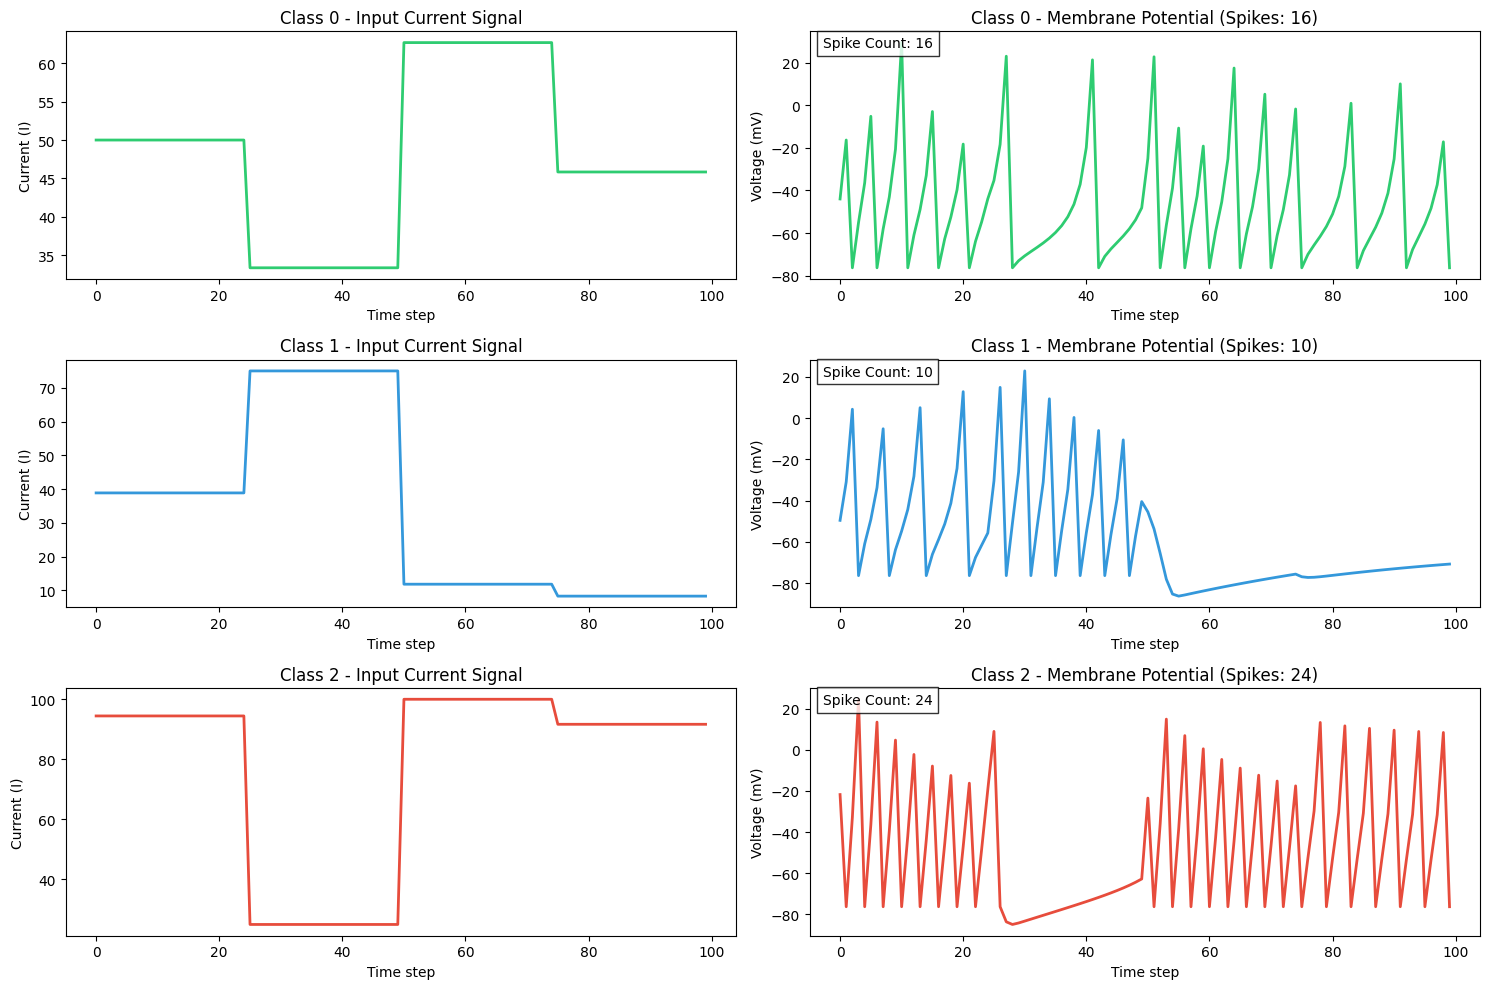

In [8]:
print("Dataset: iris.csv")
train_test_wrapper('../datasets/iris.csv')

### Accuracies for Penguins dataset:

Dataset: penguins.csv

Preprocessing data...
Preprocessed feature shape: (344, 6)
Number of classes: 3

Split sizes - Train: 275, Test: 69

Optimizing neuron parameters...

Optimal parameters: a=0.002, b=0.158, c=-40.909, d=9.927

Evaluating on test set...

Test accuracy: 0.797


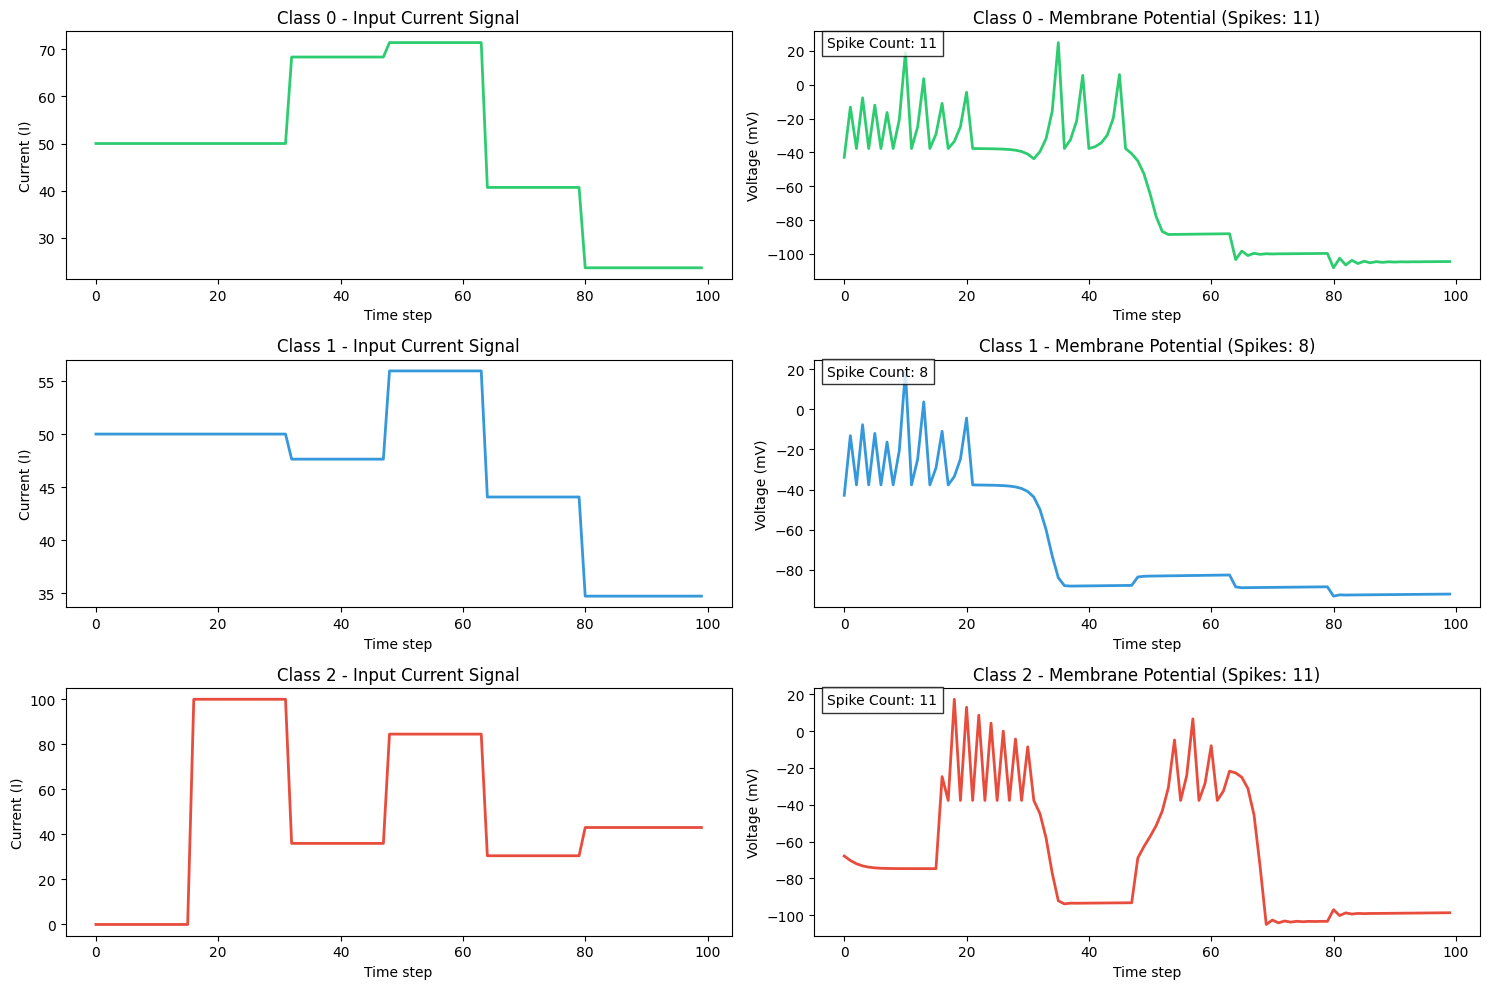

In [9]:
print("Dataset: penguins.csv")
train_test_wrapper('../datasets/penguins.csv')